# Подгружаем все что может понадобится

In [225]:
import pandas as pd
import traceback
import numpy as np
import sys
import datetime
import matplotlib.pyplot as plt
from sortedcontainers import SortedDict
import warnings
import math
from copy import deepcopy
from tqdm import tqdm
import matplotlib as mpl
import platform
from collections import Counter
from IPython.core.display import HTML
import os
from copy import deepcopy
from sklearn.metrics import f1_score
import json
from sklearn.metrics import roc_auc_score
from copy import deepcopy
from catboost import CatBoostClassifier
from statistics import median
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from lightautoml.automl.presets.tabular_presets import TabularAutoML
from lightautoml.tasks import Task
from lightautoml.validation.np_iterators import TimeSeriesIterator
from datetime import timedelta
from lightautoml.utils.profiler import Profiler
from scipy import fft 
from math import *
p = Profiler()
p.change_deco_settings({'enabled': True})
sys.path.insert(0, "/Users/a185583357/Desktop/MMZip")
from backtest_period import backtest_year
from algo_stats import algo_stats
from algo_classes import Matching_Engine
from helpers import myround

from pandarallel import pandarallel
pandarallel.initialize(progress_bar=True)
tqdm.pandas()


warnings.filterwarnings('ignore')
pd.options.display.max_rows = 10000




INFO: Pandarallel will run on 12 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.


In [226]:
#%pip install --user lightautoml

In [227]:
def y(x):
    return sin(x)

lst_x = []
lst_y = []
for i in range(10000):
    lst_x.append(i* pi/1000)
    lst_y.append(y(lst_x[-1]))

type(fft(np.array(lst_y))[2])

numpy.complex128

# Посмотрим на наши данные и почистим их

In [336]:
#fol = pd.read_csv("/Users/a185583357/Downloads/MMzip/fol/LKOH.txt", sep=",")

#TODO Inspect 20150923 - lots of errors there
date = "20150311"
try:
    fol = pd.read_csv("/Users/a185583357/Desktop/MOEX/OrderLog" + date + "/OrderLog" + date + ".txt", sep=',')
except:
    fol = pd.read_csv("/Users/a185583357/Desktop/MOEX/OrderLog" + date + ".txt", sep=',')
fol["TRADENO"] = fol["TRADENO"].astype(str)
fol.tail()

,NO,SECCODE,BUYSELL,TIME,ORDERNO,ACTION,PRICE,VOLUME,TRADENO,TRADEPRICE
27490266,27490267,SBERP,B,184459543,11875515,0,50.12,500,nan,NaN
27490267,27490268,SBERP,S,184459590,12731804,0,50.79,1000,nan,NaN
27490268,27490269,SBERP,S,184459675,12625592,0,51.12,1000,nan,NaN
27490269,27490270,SBERP,S,184459725,11086387,0,51.29,500,nan,NaN
27490270,27490271,SBERP,S,184459742,11359787,0,51.30,500,nan,NaN


In [230]:


count = Counter(fol["SECCODE"]).most_common(30)
out = []
for share in count:
    out.append(share[0])
count

[('GAZP', 2911989),
 ('SBER', 2476232),
 ('CHMF', 1507964),
 ('SNGS', 1457877),
 ('LKOH', 1368305),
 ('RTKM', 1324898),
 ('SNGSP', 1199692),
 ('ROSN', 1157663),
 ('SBERP', 1080476),
 ('HYDR', 937342),
 ('VTBR', 818308),
 ('TRNFP', 793175),
 ('MTLR', 695619),
 ('TATN', 677443),
 ('NLMK', 636415),
 ('MTSS', 619329),
 ('ALRS', 546007),
 ('MGNT', 525151),
 ('MOEX', 521223),
 ('GMKN', 518024),
 ('FEES', 423358),
 ('EONR', 413915),
 ('URKA', 399584),
 ('MAGN', 343153),
 ('RSTI', 324373),
 ('MVID', 274891),
 ('AFKS', 245138),
 ('IRAO', 215832),
 ('NVTK', 201622),
 ('RASP', 196259)]

In [231]:
fol.head(5)

,NO,SECCODE,BUYSELL,TIME,ORDERNO,ACTION,PRICE,VOLUME,TRADENO,TRADEPRICE
0,1,CLSB,B,100000000,1,1,0.0700,260000,nan,NaN
1,2,BISV,B,100000000,2,1,6.9600,100,nan,NaN
2,3,CLSB,B,100000000,3,1,0.0650,1000000,nan,NaN
3,4,CLSBP,B,100000000,4,1,0.0736,10000,nan,NaN
4,5,DZRD,S,100000000,5,1,883.0000,1,nan,NaN


#  Соберем стакан из этого

Общая идея взята из статьи - https://habr.com/ru/post/276635/

In [337]:

share = "LKOH"
data = fol[fol["SECCODE"] == share]
data = data[data["ACTION"] != 2]
data["DATE"] = date
records = data.to_dict("records")
data.reset_index(inplace=True)
data.shape

(1311311, 12)

In [233]:
data.head()

,index,NO,SECCODE,BUYSELL,TIME,ORDERNO,ACTION,PRICE,VOLUME,TRADENO,TRADEPRICE,DATE
0,11,12,LKOH,S,100000000,12,1,2720.0,4,nan,NaN,20150311
1,71,72,LKOH,B,100000000,72,1,2702.0,50,nan,NaN,20150311
2,75,76,LKOH,S,100000000,76,1,2779.9,30,nan,NaN,20150311
3,148,149,LKOH,S,100000000,149,1,2745.7,5,nan,NaN,20150311
4,149,150,LKOH,S,100000000,150,1,2795.8,5,nan,NaN,20150311


In [234]:
class Matching_Engine:
    def __init__(self):
        self.bid = SortedDict()  # descending
        self.ask = SortedDict()
        self.bid_active_order = dict()
        self.ask_active_order = dict()
        self.bid_FIFO = dict()
        self.ask_FIFO = dict()
        self.day = None
        self.share_name = "LKOH"
        self.trade_log = []

    def check_order(self, data):
        if self.day != data["DATE"]:
            self.clean_dom()
            self.share_name = data["SECCODE"]
            self.day = data["DATE"]

        if data["ACTION"] == 1:
            return self.check_add(data, new_trades=[])
        elif data["ACTION"] == 2:
            pass
        else:
            self.delete_order(data)

    ## First part - adding order

    def check_add(self, data, rec_flag=False, new_trades=[]):
        if (len(self.ask) > 0 and data['BUYSELL'] == "B" and
            (data["PRICE"] >= self.ask.peekitem(0)[0] or data["PRICE"] < 0.000001)) or \
                (len(self.bid) > 0 and data['BUYSELL'] == "S" and data["PRICE"] <= self.bid.peekitem(-1)[0]):
            if not rec_flag:
                self.add_order(data)
            return self.trade(data, new_trades=new_trades)
        else:
            if not rec_flag:
                self.add_order(data)

    def add_order(self, data):
        if data['BUYSELL'] == "B":
            self.bid_active_order[data["ORDERNO"]] = (data["PRICE"], data["VOLUME"])
            if data["PRICE"] not in self.bid:
                self.bid[data["PRICE"]] = data["VOLUME"]
                self.bid_FIFO[data["PRICE"]] = [data["ORDERNO"]]
            else:
                self.bid[data["PRICE"]] += data["VOLUME"]
                self.bid_FIFO[data["PRICE"]].append(data["ORDERNO"])
        else:
            self.ask_active_order[data["ORDERNO"]] = (data["PRICE"], data["VOLUME"])
            if data["PRICE"] not in self.ask:
                self.ask[data["PRICE"]] = data["VOLUME"]
                self.ask_FIFO[data["PRICE"]] = [data["ORDERNO"]]
            else:
                self.ask[data["PRICE"]] += data["VOLUME"]
                self.ask_FIFO[data["PRICE"]].append(data["ORDERNO"])

    ## Second part - delete order

    def delete_order(self, data):
        if data['BUYSELL'] == "B":
            self.bid_FIFO[data["PRICE"]].pop(self.bid_FIFO[data["PRICE"]].index(data["ORDERNO"]))
            self.bid[data["PRICE"]] -= self.bid_active_order[data["ORDERNO"]][1]
            if len(self.bid_FIFO[data["PRICE"]]) < 1:
                del self.bid_FIFO[data["PRICE"]]
            del self.bid_active_order[data["ORDERNO"]]
            if self.bid[data["PRICE"]] < 0.000000001:
                del self.bid[data["PRICE"]]
        else:
            self.ask[data["PRICE"]] -= self.ask_active_order[data["ORDERNO"]][1]
            self.ask_FIFO[data["PRICE"]].pop(self.ask_FIFO[data["PRICE"]].index(data["ORDERNO"]))
            if len(self.ask_FIFO[data["PRICE"]]) < 1:
                del self.ask_FIFO[data["PRICE"]]
            del self.ask_active_order[data["ORDERNO"]]
            if self.ask[data["PRICE"]] < 0.000000001:
                del self.ask[data["PRICE"]]

    ## Third part - match order
    def trade(self, data, new_trades=[]):
        if data['BUYSELL'] == "B":
            return self.exec_buy_order(data, new_trades=new_trades)
        else:
            return self.exec_sell_order(data, new_trades=new_trades)

    def exec_sell_order(self, data, new_trades=[]):
        go_trade = True
        while go_trade:
            go_trade = False
            sell_order = self.ask_active_order[data["ORDERNO"]]
            tradeprice = self.bid.peekitem(-1)[0]
            order_no = self.bid_FIFO[tradeprice][0]
            if str(order_no)[0] == 'm':
                out_no = "mm_past"
            else:
                out_no = order_no
            buy_order = self.bid_active_order[order_no]
            if buy_order[1] > sell_order[1]:
                self.bid_active_order[order_no] = (self.bid_active_order[order_no][0],
                                                   buy_order[1] - sell_order[1])
                trade_vol = sell_order[1]
                self.bid[buy_order[0]] -= trade_vol
                self.delete_order(data)
            elif buy_order[1] == sell_order[1]:
                self.delete_order(data)
                tmp = dict()
                tmp["BUYSELL"] = "B"

                tmp["PRICE"] = buy_order[0]
                tmp["ORDERNO"] = order_no

                self.delete_order(tmp)
                trade_vol = sell_order[1]
            else:
                # iseberg or error
                tmp = dict()
                tmp["BUYSELL"] = "B"
                tmp["PRICE"] = buy_order[0]
                tmp["ORDERNO"] = order_no
                self.delete_order(tmp)
                trade_vol = buy_order[1]
                self.ask[sell_order[0]] -= trade_vol
                self.ask_active_order[data["ORDERNO"]] = (self.ask_active_order[data["ORDERNO"]][0],
                                                          sell_order[1] - buy_order[1])
                # TODO не учтено полное пробитие стакана!!
                if len(self.bid) == 0:
                    #reject стакан пробит
                    go_trade = False
                    #print("пробит стакан")
                elif self.bid.peekitem(-1)[0] >= sell_order[0] or data["PRICE"] < 0.000000001:
                    go_trade = True

            self.trade_log.append(
                [tradeprice, trade_vol, data["ORDERNO"], out_no, tradeprice * trade_vol, data["TIME"], data["NO"], "S"])
            new_trades.append(self.trade_log[-1])
            if buy_order[1] < 0 or sell_order[1] < 0:
                print("Maybe error", buy_order, sell_order)
                raise Exception(buy_order, sell_order)
            if go_trade:
                data["VOLUME"] -= trade_vol
                self.ask_active_order[data["ORDERNO"]] = (self.ask_active_order[data["ORDERNO"]][0], data["VOLUME"])
                # self.ask[data["PRICE"]] -= data["VOLUME"]
                # return self.check_add(data, rec_flag=True, new_trades=new_trades)
        return new_trades

    def exec_buy_order(self, data, new_trades=[]):
        go_trade = True
        while go_trade:
            go_trade = False
            buy_order = self.bid_active_order[data["ORDERNO"]]
            tradeprice = self.ask.peekitem(0)[0]
            order_no = self.ask_FIFO[tradeprice][0]
            if str(order_no)[0] == 'm':
                out_no = "mm_past"
            else:
                out_no = order_no
            sell_order = self.ask_active_order[order_no]
            if sell_order[1] > buy_order[1]:
                self.ask_active_order[order_no] = (self.ask_active_order[order_no][0],
                                                   sell_order[1] - buy_order[1])
                trade_vol = buy_order[1]
                self.ask[sell_order[0]] -= trade_vol
                self.delete_order(data)
            elif buy_order[1] == sell_order[1]:
                self.delete_order(data)
                tmp = dict()
                tmp["BUYSELL"] = "S"
                tmp["PRICE"] = sell_order[0]
                tmp["ORDERNO"] = self.ask_FIFO[tradeprice][0]
                self.delete_order(tmp)
                trade_vol = sell_order[1]
            else:
                # iseberg or error
                tmp = dict()
                tmp["BUYSELL"] = "S"
                tmp["PRICE"] = sell_order[0]
                tmp["ORDERNO"] = order_no
                self.delete_order(tmp)
                trade_vol = sell_order[1]
                self.bid[buy_order[0]] -= trade_vol
                self.bid_active_order[data["ORDERNO"]] = (self.bid_active_order[data["ORDERNO"]][0],
                                                          buy_order[1] - sell_order[1])
                if len(self.ask) == 0:
                    #reject стакан пробит
                    go_trade = False
                elif self.ask.peekitem(0)[0] <= buy_order[0] or data["PRICE"] < 0.000000001:
                    go_trade = True

            # TODO Мне кажется здесь потенциальная ошибка, не предусмотрено что аркет мейкер заявка может в кого то удариться
            self.trade_log.append(
                [tradeprice, trade_vol, data["ORDERNO"], out_no, tradeprice * trade_vol, data["TIME"], data["NO"], "B"])
            new_trades.append(self.trade_log[-1])
            if buy_order[1] < 0 or sell_order[1] < 0:
                print("Maybe error", buy_order, sell_order)
                raise Exception(buy_order, sell_order)
            if go_trade:
                data["VOLUME"] -= trade_vol
                self.bid_active_order[data["ORDERNO"]] = (self.bid_active_order[data["ORDERNO"]][0], data["VOLUME"])
                # self.bid[data["PRICE"]] -= data["VOLUME"]
                return self.check_add(data, rec_flag=True, new_trades=new_trades)
        return new_trades

    ## Others

    def clean_dom(self):
        self.__init__()


In [236]:
dom = Matching_Engine()
errors = 0
isebergs = pd.read_csv("/Users/a185583357/Desktop/MOEX/OrderLog" + date + "/isebergs_" + share + date + ".csv", index_col=0).to_dict()["vol"]

for i in tqdm(range(len(records))):
    record = records[i].copy()
    if record["ACTION"] == 1 and record["ORDERNO"] in isebergs:
        record["VOLUME"] = isebergs[record["ORDERNO"]]
    try:
        out = dom.check_order(record)
    except Exception as e:
        #print(e)
        if record["ACTION"] == 1:
            print("MAYBE Some problem, cant add order")
            dom.check_order(record)
            raise Exception
        errors += 1

100%|██████████| 1311311/1311311 [00:06<00:00, 194378.10it/s]


In [237]:
dom.trade_log[-1]

[2719.0, 4, 13484038, 13483855, 10876.0, 183958997, 27488005, 'S']

# Теперь сделаем заготовку для ML, для этого соберем numpy array снапшота стакана и последих трейдов

In [238]:
deep = 1

In [239]:
def RSI (data, time_window):
    diff = data.diff(1).dropna()        # diff in one field(one day)

    #this preservers dimensions off diff values
    up_chg = deepcopy(0 * diff)
    down_chg = deepcopy(0 * diff)
    
    # up change is equal to the positive difference, otherwise equal to zero
    up_chg[diff > 0] = diff[ diff>0 ]
    
    # down change is equal to negative deifference, otherwise equal to zero
    down_chg[diff < 0] = diff[ diff < 0 ]
   
    
    # check pandas documentation for ewm
    # https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.ewm.html
    # values are related to exponential decay
    # we set com=time_window-1 so we get decay alpha=1/time_window
    
    up_chg_avg   = up_chg.mean()
    down_chg_avg = down_chg.mean()
    
    if down_chg_avg == 0:
        return 100.0
    rs = abs(up_chg_avg/down_chg_avg)
    rsi = 100 - 100/(1+rs)
    return rsi

In [240]:
def VWAP(trade_log, record, vwap, top_price, min_price, timerange=1):
    timenow = datetime.datetime.strptime(str(record["TIME"]), '%H%M%S%f')
    time_log = pd.to_datetime(pd.Series(np.array(trade_log)[:, -3]), format='%H%M%S%f')
    trades_window = np.array(trade_log)[time_log > (timenow - datetime.timedelta(seconds=timerange))]
    if trades_window.shape[0] == 0:
        return vwap, top_price, min_price
    else:
        return sum(trades_window[:, 0].astype(float) * trades_window[:, 1].astype(int)) /  sum(trades_window[:, 1].astype(int)), max(trades_window[:, 0].astype(float)), min(trades_window[:, 0].astype(float))

In [241]:
tmp = datetime.datetime.strptime(str(record["TIME"]), '%H%M%S%f')
time_log = pd.to_datetime(pd.Series(np.array(dom.trade_log)[:, -3]), format='%H%M%S%f')
tmp = np.array(dom.trade_log)[time_log > (tmp - datetime.timedelta(seconds=500))]
max(tmp[:, 0].astype(float))

2734.3

In [257]:
sma5, sma10, sma30, sma50, sma100 = 0, 0, 0, 0, 0
ema5, ema10, ema30, ema100 = 0, 0, 0, 0
std10, std50, std100, std1000 = 0, 0, 0, 0
rsi14, rsi50, rsi100, rsi300 = 0, 0, 0, 0
vwap1, vwap30, vwap60 = 0, 0, 0
top_price1, top_price30, top_price60 = 0, 0, 0
min_price1, min_price30, min_price60 = 0, 0, 0

def get_technical_indicator(change, trade_log, output, record):
    #TODO это однозначно можно сделать оптимальнее!!
    global deep
    global sma5, sma10, sma30, sma50, sma100
    global ema5, ema10, ema30, ema100
    global std10, std50, std100, std1000 
    global rsi14, rsi50, rsi100, rsi300
    global vwap1, vwap30, vwap60
    global top_price1, top_price30, top_price60
    global min_price1, min_price30, min_price60
    if change != 0:        
        sma5 = np.array(trade_log[-5:])[:, 0].astype(float).mean()
        sma10 = np.array(trade_log[-10:])[:, 0].astype(float).mean()
        sma30 = np.array(trade_log[-30:])[:, 0].astype(float).mean()
        sma50 = np.array(trade_log[-50:])[:, 0].astype(float).mean()
        sma100 = np.array(trade_log[-100:])[:, 0].astype(float).mean()
        #EMA
        ema5 = pd.DataFrame(np.array(trade_log[-5:])[:, 0].astype(float)).ewm(span=5).mean().iat[-1, 0]
        ema10 = pd.DataFrame(np.array(trade_log[-10:])[:, 0].astype(float)).ewm(span=10).mean().iat[-1, 0]
        ema30 = pd.DataFrame(np.array(trade_log[-30:])[:, 0].astype(float)).ewm(span=30).mean().iat[-1, 0]
        ema100 = pd.DataFrame(np.array(trade_log[-100:])[:, 0].astype(float)).ewm(span=30).mean().iat[-1, 0]
        #std
        std10 = np.array(trade_log[-10:])[:, 0].astype(float).std()
        std50 = np.array(trade_log[-50:])[:, 0].astype(float).std()
        std100 = np.array(trade_log[-100:])[:, 0].astype(float).std()
        std1000 = np.array(trade_log[-1000:])[:, 0].astype(float).std()
        #RSI
        rsi14 = RSI(pd.Series(np.array(trade_log[-14:])[:, 0].astype(float)), 14)
        rsi50 = RSI(pd.Series(np.array(trade_log[-50:])[:, 0].astype(float)), 50)
        rsi100 = RSI(pd.Series(np.array(trade_log[-100:])[:, 0].astype(float)), 100)
        rsi300 = RSI(pd.Series(np.array(trade_log[-300:])[:, 0].astype(float)), 300)
        #VWAP, top, min
        vwap1, top_price1, min_price1 = VWAP(trade_log[-1000:], record, vwap1, top_price1, min_price1, timerange=1)
        vwap30, top_price30, min_price30 = VWAP(trade_log[-3000:], record, vwap30, top_price30, min_price60, timerange=30)
        vwap60, top_price60, min_price60 = VWAP(trade_log[-5000:], record, vwap60, top_price30, min_price60, timerange=60)
    output[deep * 4 + 7] = sma5
    output[deep * 4 + 8] = sma10
    output[deep * 4 + 9] = sma30
    output[deep * 4 + 10] = sma50
    output[deep * 4 + 11] = sma100
    #EMA
    output[deep * 4 + 12] = ema5
    output[deep * 4 + 13] = ema10
    output[deep * 4 + 14] = ema30
    output[deep * 4 + 15] = ema100
    #std
    output[deep * 4 + 16] = std10
    output[deep * 4 + 17] = std50
    output[deep * 4 + 18] = std100
    output[deep * 4 + 19] = std1000
    #RSI
    output[deep * 4 + 20] = rsi14
    output[deep * 4 + 21] = rsi50
    output[deep * 4 + 22] = rsi100
    output[deep * 4 + 23] = rsi300
    #VWAP
    output[deep * 4 + 24] = vwap1
    output[deep * 4 + 25] = vwap30
    output[deep * 4 + 26] = vwap60
    #top
    output[deep * 4 + 27] = top_price1
    output[deep * 4 + 28] = top_price30
    output[deep * 4 + 29] = top_price60
    #min
    output[deep * 4 + 30] = min_price1
    output[deep * 4 + 31] = min_price30
    output[deep * 4 + 32] = min_price60
    # moment liquidity
    output[deep * 4 + 33] = 0
    output[deep * 4 + 34] = 0
    for i in range(0, deep):
        output[deep * 4 + 33] += output[deep * 4 + 1]
        output[deep * 4 + 34] += output[deep * 4 + 3]

    if (output[deep * 4 + 33] + output[deep * 4 + 34]) != 0:
        output[deep * 4 + 35] = output[deep * 4 + 33] / (output[deep * 4 + 33] + output[deep * 4 + 34])
    else:
        output[deep * 4 + 35] = 0
    
    return output

In [298]:
def construct_raw(dom, deep, raw_data, record):
    output = [0] * (deep * 4 + 36)
    trade_log = dom.trade_log
    bids = list(dom.bid.items())
    asks = list(dom.ask.items())
    for i in range(0, deep):
        if len(bids) > i:
            #print(bids[-1], i)
            output[(2 * deep) - 2 * i - 1] = bids[-i - 1][1]
            output[(2 * deep) - 2 * i - 2] = bids[-i - 1][0]
        if len(asks) > i:
            #print(asks, i)
            output[(2 * deep) + 2 * i + 1] = asks[i][1]
            output[(2 * deep) + 2 * i] = asks[i][0]
    if len(dom.trade_log) > 0:
        #print(dom.trade_log[-1])
        output[deep * 4] = dom.trade_log[-1][0]
        output[deep * 4 + 1] = dom.trade_log[-1][1]
        if output[deep * 4 + 2] == "B":
            output[deep * 4 + 2] = -1
        else:
            output[deep * 4 + 2] = 1
        if len(raw_data) != 0:
            change = raw_data[-1][deep * 4] - output[deep * 4]
        else:
            change = 0
        if change == 0:
            output[deep * 4 + 3] = 0
        elif change > 0:
            output[deep * 4 + 3] = -1
        else:
            output[deep * 4 + 3] = 1
            
        output[deep * 4 + 4] = dom.trade_log[-1][-3]
    output[deep * 4 + 5] = int(record["DATE"])
    output[deep * 4 + 6] = record["TIME"]
    
    
    if len(trade_log) > 50:
        output = get_technical_indicator(change, trade_log, output, record)
    
    
    return output

In [259]:
def get_data(date, records, deep):
    dom = Matching_Engine()
    errors = 0
    isebergs = pd.read_csv("/Users/a185583357/Desktop/MOEX/OrderLog" + date + "/isebergs_" + share + date + ".csv", index_col=0).to_dict()["vol"]
    raw_data = []

    for i in tqdm(range(len(records))):
        record = records[i].copy()
        if record["ACTION"] == 1 and record["ORDERNO"] in isebergs:
            record["VOLUME"] = isebergs[record["ORDERNO"]]
        try:
            out = dom.check_order(record)
            raw_data.append(construct_raw(dom, deep, raw_data, record))
        except Exception as e:
            #print(e)
            if record["ACTION"] == 1:
                print("MAYBE Some problem, cant add order")
                dom.check_order(record)
                raise Exception
            raw_data.append(construct_raw(dom, deep, raw_data, record))
            errors += 1
    return raw_data


raw_data = get_data(date, records, deep)
#raw_data[1000]
len(raw_data)

100%|██████████| 1311311/1311311 [19:26<00:00, 1123.73it/s]


1311311

In [245]:
def find_nearest(raw, future1, future30, future60):
    dt = raw.Time
    nearest1 = future1.iloc[future1.index.get_loc(dt, method='nearest')]
    nearest30 = future30.iloc[future30.index.get_loc(dt, method='nearest')]
    nearest60 = future60.iloc[future60.index.get_loc(dt, method='nearest')]
    raw["FutureVWAP1"] = nearest1["FutureVWAP1"]
    raw["MIN1"] = nearest1["MIN1"]
    raw["TOP1"] = nearest1["TOP1"]    
    raw["FutureVWAP30"] = nearest30["FutureVWAP30"]
    raw["MIN30"] = nearest30["MIN30"]
    raw["TOP30"] = nearest30["TOP30"]
    raw["FutureVWAP60"] = nearest60["FutureVWAP60"]
    raw["MIN60"] = nearest60["MIN60"]
    raw["TOP60"] = nearest60["TOP60"]
    return raw
    


def create_future_vwap(snapchot):
    snapchot["FutureVWAP1"] = deepcopy(snapchot["VWAP1"])
    snapchot["FutureVWAP30"] = deepcopy(snapchot["VWAP30"])
    snapchot["FutureVWAP60"] = deepcopy(snapchot["VWAP60"])
    future1 = deepcopy(snapchot.shift(freq=-timedelta(seconds=1)))
    future30 = deepcopy(snapchot.shift(freq=-timedelta(seconds=30)))
    future60 = deepcopy(snapchot.shift(freq=-timedelta(seconds=60)))
    try:
        snapchot = snapchot.parallel_apply(find_nearest, args=(future1, future30, future60), axis=1)
    except:
        snapchot = snapchot.progress_apply(find_nearest, args=(future1, future30, future60), axis=1)
    snapchot["Difference1"] = snapchot["FutureVWAP1"] - snapchot["VWAP1"]
    snapchot["Difference30"] = snapchot["FutureVWAP30"] - snapchot["VWAP30"]
    snapchot["Difference60"] = snapchot["FutureVWAP60"] - snapchot["VWAP60"]
    snapchot["IsUp1"] = np.sign(snapchot["Difference1"])
    snapchot["IsUp30"] = np.sign(snapchot["Difference30"])
    snapchot["IsUp60"] = np.sign(snapchot["Difference60"])
    return snapchot
    

In [246]:
pd.DataFrame(raw_data).to_csv("../" + share + date + ".csv")

In [247]:
raw_data = pd.read_csv("../" + share + date + ".csv").drop(['Unnamed: 0'], axis=1)
raw_data = raw_data.values.tolist()

In [282]:
np.array(raw_data)

array([[0.000e+00, 0.000e+00, 2.720e+03, ..., 0.000e+00, 0.000e+00,
        0.000e+00],
       [2.702e+03, 5.000e+01, 2.720e+03, ..., 0.000e+00, 0.000e+00,
        0.000e+00],
       [2.702e+03, 5.000e+01, 2.720e+03, ..., 0.000e+00, 0.000e+00,
        0.000e+00],
       ...,
       [2.706e+03, 2.000e+00, 2.720e+03, ..., 4.000e+00, 0.000e+00,
        1.000e+00],
       [2.706e+03, 2.000e+00, 2.720e+03, ..., 4.000e+00, 0.000e+00,
        1.000e+00],
       [2.706e+03, 2.000e+00, 2.720e+03, ..., 4.000e+00, 0.000e+00,
        1.000e+00]])

In [279]:
def get_df_y(raw_data, deep):
    columns = []
    for col in ["Bid", "Ask"]:
        for num in range(1, 1 + deep):
            if col == "Bid":
                num = deep - num + 1
            columns.append(col + "Price" + str(num))
            columns.append(col + "Volume" + str(num))
    dupl_col = deepcopy(columns)
    columns += ["Last Trade Price"] + ["Last Trade Volume"] + ["Side"] + ["isNewTrade"] + \
    ["LastDealTime"] + ["Date"] + ["Time"] + ["SMA5"] + ["SMA10"] + ["SMA30"] + ["SMA50"] + ["SMA100"] +\
    ["EMA5"] + ["EMA10"] + ["EMA30"] + ["EMA100"] + ["STD10"] + ["STD50"] + ["STD100"] + ["STD1000"] +\
    ["RSI14"] + ["RSI50"] + ["RSI100"] + ["RSI300"] + ["VWAP1"] + ["VWAP30"] + ["VWAP60"] +\
    ["TOP1"] + ["TOP30"] + ["TOP60"] + ["MIN1"] + ["MIN30"] + ["MIN60"] + \
    ["LiquidityBid"] + ['LiquidityAsk'] + ["BidLiquidityRatio"]
    snapschot = pd.DataFrame(np.stack(raw_data, axis=0), columns=columns)
    """
    snapschot["LiquidityBid"] = 0
    snapschot["LiquidityAsk"] = 0
    for i in range(1, 1 + deep):
        snapschot['LiquidityAsk'] += snapschot["AskVolume" + str(i)]
        snapschot["LiquidityBid"] += snapschot["BidVolume" + str(i)]

    snapschot["BidLiquidityRatio"] = snapschot["LiquidityBid"] / (snapschot["LiquidityBid"] + snapschot["LiquidityAsk"])
    """
    copy_snapschot = deepcopy(snapschot)
    snapschot = snapschot[snapschot["Time"] > 100002000.0]
    
    snapschot.drop_duplicates(subset=dupl_col,inplace=True)
    
    snapschot.index = snapschot["Time"]
    snapschot = snapschot[~snapschot.index.duplicated(keep='last')]
    tmp_time = deepcopy(snapschot.index)
    snapschot["Time"] = pd.to_datetime((snapschot["Time"]), format='%H%M%S%f')
    snapschot.index = snapschot["Time"]
    snapschot = create_future_vwap(snapschot)
    snapschot["Time"] = tmp_time
    y = np.array(snapschot["IsUp60"])
    drop_col = ["IsUp1", "IsUp30", "IsUp60", "Difference1", "Difference30", "Difference60",
                "FutureVWAP1", "FutureVWAP30", "FutureVWAP60", "Time"]
    df = snapschot.drop(drop_col, axis=1)
    return df, np.array(y), snapschot, copy_snapschot

df, y, snapschot, copy_snapschot = get_df_y(raw_data, deep)
snapschot.to_csv(share + date + ".csv")

In [302]:
def delete_time(raw_data):
    pred_raw = np.array(raw_data)
    return np.concatenate((pred_raw[:,:deep * 4 + 6], pred_raw[:,deep * 4 + 7:]), axis=1)

## Attention надо обязательно сделать задержку и смещение

Данные готовы, по одному дню сбера. теперь посмотрим на них

## Здесь будут графики и анализ существующих данных

In [260]:
copy_snapschot[30000:30005]

,BidPrice1,BidVolume1,AskPrice1,AskVolume1,Last Trade Price,Last Trade Volume,Side,isNewTrade,LastDealTime,Date,...,VWAP60,TOP1,TOP30,TOP60,MIN1,MIN30,MIN60,LiquidityBid,LiquidityAsk,BidLiquidityRatio
30000,2731.0,40.0,2731.2,4.0,2731.0,70.0,1.0,0.0,100553471.0,20150311.0,...,2731.667982,2731.1,2731.9,2732.6,2731.0,2731.0,2730.8,40.0,4.0,0.909091
30001,2731.0,40.0,2731.2,4.0,2731.0,70.0,1.0,0.0,100553471.0,20150311.0,...,2731.667982,2731.1,2731.9,2732.6,2731.0,2731.0,2730.8,40.0,4.0,0.909091
30002,2731.0,40.0,2731.2,4.0,2731.0,70.0,1.0,0.0,100553471.0,20150311.0,...,2731.667982,2731.1,2731.9,2732.6,2731.0,2731.0,2730.8,40.0,4.0,0.909091
30003,2731.0,40.0,2731.2,4.0,2731.0,70.0,1.0,0.0,100553471.0,20150311.0,...,2731.667982,2731.1,2731.9,2732.6,2731.0,2731.0,2730.8,40.0,4.0,0.909091
30004,2731.0,40.0,2731.2,4.0,2731.0,70.0,1.0,0.0,100553471.0,20150311.0,...,2731.667982,2731.1,2731.9,2732.6,2731.0,2731.0,2730.8,40.0,4.0,0.909091


In [261]:
copy_snapschot.shape, len(records), len(raw_data)

((1311311, 40), 1311311, 1311311)

In [262]:
visu_data = snapschot#[1500:]

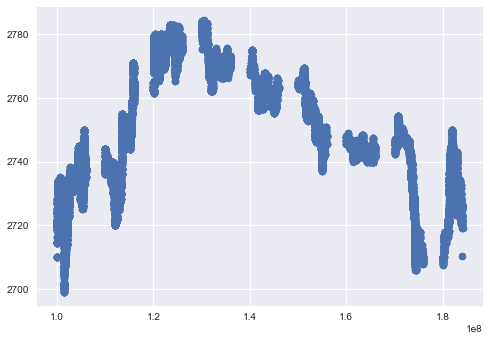

In [263]:
plt.scatter(visu_data["Time"], visu_data["Last Trade Price"])

In [264]:
pd.to_datetime((snapschot["Time"]), format='%H%M%S%f')

Time
1900-01-01 10:00:02.008   1900-01-01 10:00:02.008
1900-01-01 10:00:02.053   1900-01-01 10:00:02.053
1900-01-01 10:00:02.061   1900-01-01 10:00:02.061
1900-01-01 10:00:02.066   1900-01-01 10:00:02.066
1900-01-01 10:00:02.067   1900-01-01 10:00:02.067
                                    ...          
1900-01-01 18:40:02.464   1900-01-01 18:40:02.464
1900-01-01 18:40:27.875   1900-01-01 18:40:27.875
1900-01-01 18:41:24.273   1900-01-01 18:41:24.273
1900-01-01 18:41:24.357   1900-01-01 18:41:24.357
1900-01-01 18:41:44.373   1900-01-01 18:41:44.373
Name: Time, Length: 88775, dtype: datetime64[ns]

In [265]:
from sklearn.model_selection import TimeSeriesSplit

tscv = TimeSeriesSplit(3) 
for train_index, test_index in tscv.split(df):
    print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = np.array(df)[train_index], np.array(df)[test_index]
    y_train, y_test = y[train_index], y[test_index]

TRAIN: [    0     1     2 ... 22193 22194 22195] TEST: [22196 22197 22198 ... 44386 44387 44388]
TRAIN: [    0     1     2 ... 44386 44387 44388] TEST: [44389 44390 44391 ... 66579 66580 66581]
TRAIN: [    0     1     2 ... 66579 66580 66581] TEST: [66582 66583 66584 ... 88772 88773 88774]


In [286]:
X_train.shape

(66582, 39)

# Тут рандомные предсказания

In [266]:
def random_predict(train_data):
    return np.around(np.random.rand(train_data.shape[0]) * 2 - 1)

In [267]:
def const_predict(train_data, pred):
    out = np.zeros(train_data.shape[0]) + pred
    return out

In [268]:
Counter(random_predict(X_test)), f1_score(y_test, random_predict(X_test), average='micro')

(Counter({-0.0: 11103, 1.0: 5558, -1.0: 5532}), 0.2492677871400892)

In [269]:
const = Counter(y_test).most_common(1)[0][0]
Counter(const_predict(X_test, const)), f1_score(y_test, const_predict(X_test, const), average='micro')

(Counter({-1.0: 22193}), 0.5467039156490785)

In [270]:
Counter(y_test)

Counter({1.0: 10053, -1.0: 12133, 0.0: 7})

# Тут Лог Регрессия

In [271]:
lr = LogisticRegression()
lr.fit(X_train, y_train)
Counter(lr.predict(X_train)), f1_score(y_train, lr.predict(X_train), average='micro')

(Counter({1.0: 57784, -1.0: 8798}), 0.6391517226878135)

## Тут Random forest

In [272]:
rf = RandomForestClassifier()
rf.fit(X_train, y_train)

RandomForestClassifier()

In [273]:
Counter(rf.predict(X_train)), f1_score(y_train, rf.predict(X_train), average='micro')

(Counter({1.0: 41296, -1.0: 25271, 0.0: 15}), 1.0)

In [274]:
Counter(rf.predict(X_test)), f1_score(y_test, rf.predict(X_test), average='micro')

(Counter({1.0: 18378, -1.0: 3815}), 0.5802730590726806)

In [275]:
np.argsort(rf.feature_importances_)[::-1]

array([24, 29,  8, 35, 32, 25, 26, 22, 14, 34, 23, 31, 13, 28, 21, 12, 20,
       18, 17, 11, 19, 16, 33, 15, 10, 30, 27,  2,  4,  0,  5, 37,  3, 36,
        1, 38,  7,  9,  6])

Feature ranking:
1. feature RSI50 (0.106061)
2. feature VWAP60 (0.066478)
3. feature LastDealTime (0.064579)
4. feature MIN60 (0.064443)
5. feature TOP60 (0.063850)
6. feature RSI100 (0.054974)
7. feature RSI300 (0.051478)
8. feature STD1000 (0.044744)
9. feature SMA100 (0.037140)
10. feature MIN30 (0.035676)
11. feature RSI14 (0.032849)
12. feature TOP30 (0.032266)
13. feature SMA50 (0.032249)
14. feature VWAP30 (0.032075)
15. feature STD100 (0.029757)
16. feature SMA30 (0.025636)
17. feature STD50 (0.022578)
18. feature EMA100 (0.021460)
19. feature EMA30 (0.019926)
20. feature SMA10 (0.016727)
21. feature STD10 (0.016186)
22. feature EMA10 (0.014528)
23. feature MIN1 (0.014194)
24. feature EMA5 (0.013210)
25. feature SMA5 (0.012955)
26. feature TOP1 (0.012895)
27. feature VWAP1 (0.012787)
28. feature AskPrice1 (0.010517)
29. feature Last Trade Price (0.010044)
30. feature BidPrice1 (0.009656)
31. feature Last Trade Volume (0.005640)
32. feature LiquidityAsk (0.002849)
33. feature As

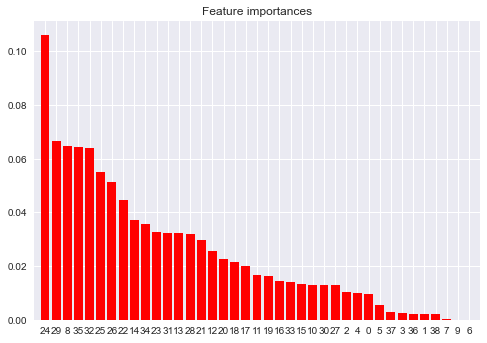

In [276]:
def get_importance(model, importance):    
    indices = np.argsort(importance)[::-1]

    # Print the feature ranking
    print("Feature ranking:")

    for f in range(X_train.shape[1]):
        print("%d. feature %s (%f)" % (f + 1, df.columns[indices[f]], importance[indices[f]]))
    plt.figure()
    plt.title("Feature importances")
    plt.bar(df.columns[indices], importance[indices],
            color="r", align="center")
    plt.xticks(df.columns[indices], indices)
    plt.xlim([-1, X_train.shape[1]])
    plt.show()
    

get_importance(rf, rf.feature_importances_)

In [312]:
pred_raw = np.array([construct_raw(dom, deep, raw_data, record)])
pred_raw = np.concatenate((pred_raw[:,:deep * 4 + 6], pred_raw[:,deep * 4 + 7:]), axis=1)
Counter(rf.predict(delete_time([construct_raw(dom, deep, raw_data, record)])))

Counter({-1.0: 1})

In [311]:
pred_raw[:deep * 4 + 6]

array([2.70600000e+03, 2.00000000e+00, 2.72000000e+03, 1.03000000e+02,
       2.71900000e+03, 4.00000000e+00, 1.00000000e+00, 0.00000000e+00,
       1.83958997e+08, 2.01503110e+07])

## Тут Catboost

In [197]:
cbst = CatBoostClassifier()
cbst.fit(pd.DataFrame(X_train), y_train)


Learning rate set to 0.097391
0:	learn: 1.0161680	total: 43.8ms	remaining: 43.8s
1:	learn: 0.9503978	total: 71.5ms	remaining: 35.7s
2:	learn: 0.8944454	total: 95.9ms	remaining: 31.9s
3:	learn: 0.8458151	total: 118ms	remaining: 29.3s
4:	learn: 0.8049665	total: 135ms	remaining: 26.8s
5:	learn: 0.7672807	total: 159ms	remaining: 26.3s
6:	learn: 0.7372873	total: 182ms	remaining: 25.8s
7:	learn: 0.7103355	total: 208ms	remaining: 25.8s
8:	learn: 0.6858040	total: 228ms	remaining: 25.1s
9:	learn: 0.6648084	total: 252ms	remaining: 24.9s
10:	learn: 0.6446640	total: 270ms	remaining: 24.3s
11:	learn: 0.6262345	total: 286ms	remaining: 23.5s
12:	learn: 0.6097452	total: 303ms	remaining: 23s
13:	learn: 0.5923035	total: 323ms	remaining: 22.8s
14:	learn: 0.5780037	total: 349ms	remaining: 22.9s
15:	learn: 0.5640454	total: 371ms	remaining: 22.8s
16:	learn: 0.5518739	total: 398ms	remaining: 23s
17:	learn: 0.5413807	total: 417ms	remaining: 22.7s
18:	learn: 0.5308666	total: 434ms	remaining: 22.4s
19:	learn: 0

169:	learn: 0.1819804	total: 3.32s	remaining: 16.2s
170:	learn: 0.1804155	total: 3.34s	remaining: 16.2s
171:	learn: 0.1797021	total: 3.35s	remaining: 16.2s
172:	learn: 0.1790394	total: 3.37s	remaining: 16.1s
173:	learn: 0.1783932	total: 3.39s	remaining: 16.1s
174:	learn: 0.1778991	total: 3.41s	remaining: 16.1s
175:	learn: 0.1770924	total: 3.42s	remaining: 16s
176:	learn: 0.1757476	total: 3.44s	remaining: 16s
177:	learn: 0.1743587	total: 3.46s	remaining: 16s
178:	learn: 0.1732763	total: 3.48s	remaining: 16s
179:	learn: 0.1721731	total: 3.51s	remaining: 16s
180:	learn: 0.1717273	total: 3.53s	remaining: 16s
181:	learn: 0.1708375	total: 3.55s	remaining: 16s
182:	learn: 0.1704950	total: 3.57s	remaining: 15.9s
183:	learn: 0.1699732	total: 3.59s	remaining: 15.9s
184:	learn: 0.1688380	total: 3.6s	remaining: 15.9s
185:	learn: 0.1682894	total: 3.62s	remaining: 15.8s
186:	learn: 0.1671338	total: 3.64s	remaining: 15.8s
187:	learn: 0.1664594	total: 3.66s	remaining: 15.8s
188:	learn: 0.1661319	total

328:	learn: 0.0964885	total: 6.23s	remaining: 12.7s
329:	learn: 0.0963168	total: 6.25s	remaining: 12.7s
330:	learn: 0.0962202	total: 6.26s	remaining: 12.7s
331:	learn: 0.0960173	total: 6.28s	remaining: 12.6s
332:	learn: 0.0957449	total: 6.29s	remaining: 12.6s
333:	learn: 0.0954275	total: 6.31s	remaining: 12.6s
334:	learn: 0.0950999	total: 6.32s	remaining: 12.6s
335:	learn: 0.0946243	total: 6.34s	remaining: 12.5s
336:	learn: 0.0941940	total: 6.35s	remaining: 12.5s
337:	learn: 0.0937462	total: 6.37s	remaining: 12.5s
338:	learn: 0.0935810	total: 6.38s	remaining: 12.4s
339:	learn: 0.0934372	total: 6.4s	remaining: 12.4s
340:	learn: 0.0929581	total: 6.42s	remaining: 12.4s
341:	learn: 0.0926185	total: 6.43s	remaining: 12.4s
342:	learn: 0.0923267	total: 6.45s	remaining: 12.4s
343:	learn: 0.0918067	total: 6.47s	remaining: 12.3s
344:	learn: 0.0915660	total: 6.49s	remaining: 12.3s
345:	learn: 0.0911183	total: 6.5s	remaining: 12.3s
346:	learn: 0.0909098	total: 6.52s	remaining: 12.3s
347:	learn: 0.

493:	learn: 0.0597616	total: 9.37s	remaining: 9.6s
494:	learn: 0.0596750	total: 9.38s	remaining: 9.57s
495:	learn: 0.0595243	total: 9.4s	remaining: 9.55s
496:	learn: 0.0592968	total: 9.42s	remaining: 9.53s
497:	learn: 0.0591104	total: 9.44s	remaining: 9.51s
498:	learn: 0.0590100	total: 9.45s	remaining: 9.49s
499:	learn: 0.0588047	total: 9.47s	remaining: 9.47s
500:	learn: 0.0586935	total: 9.49s	remaining: 9.45s
501:	learn: 0.0584430	total: 9.51s	remaining: 9.44s
502:	learn: 0.0583062	total: 9.54s	remaining: 9.42s
503:	learn: 0.0582687	total: 9.56s	remaining: 9.4s
504:	learn: 0.0581091	total: 9.57s	remaining: 9.38s
505:	learn: 0.0579256	total: 9.59s	remaining: 9.36s
506:	learn: 0.0577152	total: 9.61s	remaining: 9.34s
507:	learn: 0.0575906	total: 9.62s	remaining: 9.32s
508:	learn: 0.0574065	total: 9.64s	remaining: 9.3s
509:	learn: 0.0571852	total: 9.65s	remaining: 9.28s
510:	learn: 0.0571058	total: 9.67s	remaining: 9.26s
511:	learn: 0.0570173	total: 9.69s	remaining: 9.24s
512:	learn: 0.05

664:	learn: 0.0416759	total: 12.3s	remaining: 6.2s
665:	learn: 0.0415628	total: 12.3s	remaining: 6.17s
666:	learn: 0.0414529	total: 12.3s	remaining: 6.16s
667:	learn: 0.0413272	total: 12.3s	remaining: 6.13s
668:	learn: 0.0412383	total: 12.4s	remaining: 6.12s
669:	learn: 0.0411109	total: 12.4s	remaining: 6.1s
670:	learn: 0.0409736	total: 12.4s	remaining: 6.08s
671:	learn: 0.0408925	total: 12.4s	remaining: 6.06s
672:	learn: 0.0407879	total: 12.4s	remaining: 6.04s
673:	learn: 0.0407213	total: 12.4s	remaining: 6.02s
674:	learn: 0.0405956	total: 12.5s	remaining: 6s
675:	learn: 0.0405078	total: 12.5s	remaining: 5.98s
676:	learn: 0.0404754	total: 12.5s	remaining: 5.96s
677:	learn: 0.0403617	total: 12.5s	remaining: 5.94s
678:	learn: 0.0402692	total: 12.5s	remaining: 5.92s
679:	learn: 0.0401835	total: 12.5s	remaining: 5.9s
680:	learn: 0.0401302	total: 12.6s	remaining: 5.88s
681:	learn: 0.0400848	total: 12.6s	remaining: 5.87s
682:	learn: 0.0400105	total: 12.6s	remaining: 5.84s
683:	learn: 0.0399

829:	learn: 0.0311493	total: 15.2s	remaining: 3.12s
830:	learn: 0.0311093	total: 15.3s	remaining: 3.1s
831:	learn: 0.0310569	total: 15.3s	remaining: 3.08s
832:	learn: 0.0309922	total: 15.3s	remaining: 3.07s
833:	learn: 0.0309453	total: 15.3s	remaining: 3.05s
834:	learn: 0.0308932	total: 15.3s	remaining: 3.03s
835:	learn: 0.0308447	total: 15.4s	remaining: 3.01s
836:	learn: 0.0308302	total: 15.4s	remaining: 3s
837:	learn: 0.0308116	total: 15.4s	remaining: 2.98s
838:	learn: 0.0307797	total: 15.4s	remaining: 2.96s
839:	learn: 0.0307265	total: 15.4s	remaining: 2.94s
840:	learn: 0.0307017	total: 15.5s	remaining: 2.92s
841:	learn: 0.0306384	total: 15.5s	remaining: 2.9s
842:	learn: 0.0305941	total: 15.5s	remaining: 2.89s
843:	learn: 0.0305575	total: 15.5s	remaining: 2.87s
844:	learn: 0.0305052	total: 15.5s	remaining: 2.85s
845:	learn: 0.0304704	total: 15.6s	remaining: 2.83s
846:	learn: 0.0304194	total: 15.6s	remaining: 2.81s
847:	learn: 0.0303691	total: 15.6s	remaining: 2.8s
848:	learn: 0.0303

992:	learn: 0.0249111	total: 18.4s	remaining: 130ms
993:	learn: 0.0248895	total: 18.4s	remaining: 111ms
994:	learn: 0.0248445	total: 18.5s	remaining: 92.8ms
995:	learn: 0.0248124	total: 18.5s	remaining: 74.2ms
996:	learn: 0.0247916	total: 18.5s	remaining: 55.7ms
997:	learn: 0.0247835	total: 18.5s	remaining: 37.1ms
998:	learn: 0.0247660	total: 18.5s	remaining: 18.5ms
999:	learn: 0.0247362	total: 18.6s	remaining: 0us


In [198]:
Counter(cbst.predict(np.array(X_train)).ravel()), f1_score(y_train, cbst.predict(np.array(X_train)), average='micro')

(Counter({1.0: 27624, -1.0: 30965, 0.0: 102}), 0.9983983915762212)

In [199]:
Counter(cbst.predict(X_test).ravel()), f1_score(y_test, cbst.predict(X_test), average='micro')

(Counter({1.0: 7293, -1.0: 12270}), 0.6801615294177784)

Feature ranking:
1. feature TOP60 (12.034475)
2. feature VWAP60 (10.982887)
3. feature STD1000 (8.523850)
4. feature RSI300 (7.684537)
5. feature STD100 (7.402677)
6. feature MIN60 (7.379553)
7. feature RSI50 (7.330646)
8. feature STD50 (5.780224)
9. feature RSI100 (5.165776)
10. feature RSI14 (3.825921)
11. feature LastDealTime (3.648316)
12. feature STD10 (3.127374)
13. feature SMA100 (2.597528)
14. feature Last Trade Volume (2.243574)
15. feature VWAP30 (1.838714)
16. feature MIN30 (1.361083)
17. feature SMA50 (1.261381)
18. feature SMA30 (1.140159)
19. feature TOP30 (1.113758)
20. feature EMA100 (0.654535)
21. feature BidVolume1 (0.640917)
22. feature VWAP1 (0.508751)
23. feature EMA10 (0.490979)
24. feature AskVolume1 (0.485899)
25. feature MIN1 (0.424960)
26. feature LiquidityBid (0.405970)
27. feature EMA30 (0.311491)
28. feature SMA10 (0.303673)
29. feature SMA5 (0.249647)
30. feature BidPrice1 (0.218028)
31. feature BidLiquidityRatio (0.216729)
32. feature EMA5 (0.197196)
33. 

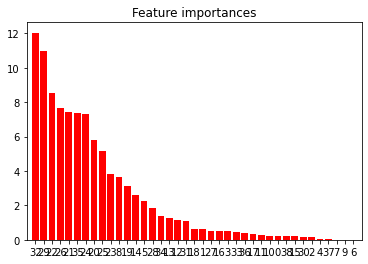

In [200]:
get_importance(cbst, cbst.get_feature_importance())

In [201]:
X_train.shape

(58691, 39)

## Тут Light auto ml


In [202]:
for train_index, test_index in tscv.split(df):
    print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = df.iloc[train_index], df.iloc[test_index]
    y_train, y_test = y[train_index], y[test_index]

TRAIN: [    0     1     2 ... 19562 19563 19564] TEST: [19565 19566 19567 ... 39125 39126 39127]
TRAIN: [    0     1     2 ... 39125 39126 39127] TEST: [39128 39129 39130 ... 58688 58689 58690]
TRAIN: [    0     1     2 ... 58688 58689 58690] TEST: [58691 58692 58693 ... 78251 78252 78253]


In [203]:
target = "IsUp60"

data_auto = snapschot.drop(["IsUp30", "IsUp1", "Difference1", "Difference30", "Difference60",
                "FutureVWAP1", "FutureVWAP30", "FutureVWAP60"], axis=1)

train_feat = []
for i in range(deep):
    train_feat += ['BidPrice'+ str(i + 1), 'BidVolume'+ str(i + 1), 'AskPrice'+ str(i + 1), 'AskVolume' + str(i + 1)]
train_feat = ['Last Trade Price', 'Last Trade Volume', 'Side', 'isNewTrade',
       'LastDealTime', 'Date', 'SMA5', 'SMA10', 'SMA30', 'SMA50',
       'SMA100', 'EMA5', 'EMA10', 'EMA30', 'EMA100', 'STD10', 'STD50',
       'STD100', 'STD1000', 'RSI14', 'RSI50', 'RSI100', 'RSI300', 'VWAP1',
       'VWAP30', 'VWAP60', 'TOP1', 'TOP30', 'TOP60', 'MIN1', 'MIN30', 'MIN60',
       'LiquidityBid', 'LiquidityAsk', 'BidLiquidityRatio']

train = {'data': data_auto[train_feat].values,
        'target': data_auto[target].values}


In [204]:
data = X_train
train_deat = X_train.columns
train = {'data': data[train_feat].values,
        'target':  y_train + 1}
test = X_test[train_feat]

In [205]:
data[train_feat].values[0]

array([2.78890000e+03, 1.90000000e+01, 1.00000000e+00, 0.00000000e+00,
       1.00001988e+08, 2.01503100e+07, 2.78822000e+03, 2.78786000e+03,
       2.78685000e+03, 2.78464400e+03, 2.78304118e+03, 2.78832275e+03,
       2.78808711e+03, 2.78732896e+03, 2.78653380e+03, 1.24515059e+00,
       3.66852341e+00, 4.17820801e+00, 4.17820801e+00, 5.26946108e+01,
       5.56832695e+01, 5.58030481e+01, 5.58030481e+01, 2.78493089e+03,
       2.78196886e+03, 2.78196886e+03, 2.79400000e+03, 2.79990000e+03,
       2.79990000e+03, 2.78720000e+03, 2.78560000e+03, 2.78210000e+03,
       2.46000000e+02, 2.01000000e+02, 5.50335570e-01])

In [206]:
cv_iter = TimeSeriesIterator(np.array(snapschot.Time)[train_index].astype('datetime64[ns]'), n_splits=5, sorted_kfold=False)

task = Task('multiclass', loss="f1", metric="auc")

automl = TabularAutoML(task=task, timeout=60 * 30, memory_limit=8)
oof_pred = automl.fit_predict(train, train_features=train_feat, roles={'target': target}, cv_iter=cv_iter)
# prediction can be made on file by
#test = data[train_feat]
test.to_csv('temp_test_data.csv', index=False)
test_pred = automl.predict('temp_test_data.csv', batch_size=20000, n_jobs=8)

print('Check scores...')
oof_prediction = oof_pred.data[:, 0]
not_empty = np.logical_not(np.isnan(oof_prediction))



sklearn doesn't support in general case f1 and will not be used.
cb doesn't support in general case f1 and will not be used.


Start automl preset with listed constraints:
- time: 1800 seconds
- cpus: 4 cores
- memory: 8 gb

Train data shape: (58691, 36)
Feats was rejected during automatic roles guess: []


Layer 1 ...
Train process start. Time left 1790.06329703331 secs
Start fitting Lvl_0_Pipe_0_Mod_0_LinearL2 ...
Linear model: C = 1e-05 score = 0.8800824601488823
Linear model: C = 5e-05 score = 0.9068018647095161
Linear model: C = 0.0001 score = 0.9154249466412026
Linear model: C = 0.0005 score = 0.9386292137883158
Linear model: C = 0.001 score = 0.9466210222109
Linear model: C = 0.005 score = 0.9566302684498768
Linear model: C = 0.01 score = 0.9561124020688779
Linear model: C = 0.05 score = 0.9421848392132466
Linear model: C = 1e-05 score = 0.9795151914771142
Linear model: C = 5e-05 score = 0.9843132870191167
Linear model: C = 0.0001 score = 0.9999085629917985
Linear model: C = 0.0005 score = 0.9999224310793489
Linear model: C = 0.001 score = 0.9999319938133694
Linear model: C = 0.005 score = 0.99994577788

Model Lvl_0_Pipe_0_Mod_0_LinearL2 failed during ml_algo.fit_predict call.

Number of classes in y_true not equal to the number of columns in 'y_score'


AssertionError: Pipeline finished with 0 models for some reason.
Probably one or more models failed

In [ ]:
data[train_feat].to_csv('temp_train_data.csv', index=False)
train_pred = automl.predict('temp_train_data.csv', batch_size=20000, n_jobs=6)

print('Check scores...')


In [ ]:
oof_pred 

In [ ]:
print('OOF score: {}'.format(f1_score(y_train + 1, np.argmax(train_pred.data, axis=1), average='micro')))
print('TEST score: {}'.format(f1_score(y_test + 1, np.argmax(test_pred.data, axis=1), average='micro')))

In [ ]:
(Counter(np.argmax(train_pred.data, axis=1) -  y_train - 1), 
Counter(np.argmax(test_pred.data, axis=1) -  y_test - 1))

In [ ]:
Counter(np.argmax(train_pred.data, axis=1)), Counter(y_train)

In [ ]:
Counter(np.argmax(test_pred.data, axis=1)), Counter(y_test)

# AutoML вторая попытка

In [207]:
import numpy as np
import pandas as pd
from sklearn.metrics import roc_auc_score, log_loss
from sklearn.model_selection import train_test_split
import torch

# Imports from our package
from lightautoml.automl.base import AutoML
from lightautoml.automl.blend import WeightedBlender
from lightautoml.ml_algo.boost_lgbm import BoostLGBM
from lightautoml.ml_algo.linear_sklearn import LinearLBFGS
from lightautoml.ml_algo.tuning.optuna import OptunaTuner
from lightautoml.pipelines.features.lgb_pipeline import LGBSimpleFeatures, LGBAdvancedPipeline
from lightautoml.pipelines.features.linear_pipeline import LinearFeatures
from lightautoml.pipelines.ml.base import MLPipeline
from lightautoml.pipelines.selection.importance_based import ModelBasedImportanceEstimator, ImportanceCutoffSelector
from lightautoml.reader.base import PandasToPandasReader
from lightautoml.tasks import Task
from lightautoml.utils.profiler import Profiler
from lightautoml.utils.timer import PipelineTimer

In [208]:
p = Profiler()
p.change_deco_settings({'enabled': True})
timer = PipelineTimer(2000, mode=2)
timer_gbm = timer.get_task_timer('gbm') # Get task timer from pipeline timer
feat_sel_0 = LGBSimpleFeatures()
mod_sel_0 = BoostLGBM(timer=timer_gbm)
imp_sel_0 = ModelBasedImportanceEstimator()
selector_0 = ImportanceCutoffSelector(feat_sel_0, mod_sel_0, imp_sel_0, cutoff=0, )

feats_gbm_0 = LGBAdvancedPipeline(top_intersections=4,
                                  output_categories=True,
                                  feats_imp=imp_sel_0)
timer_gbm_0 = timer.get_task_timer('gbm')
timer_gbm_1 = timer.get_task_timer('gbm')

gbm_0 = BoostLGBM(timer=timer_gbm_0)
gbm_1 = BoostLGBM(timer=timer_gbm_1)

tuner_0 = OptunaTuner(n_trials=20, timeout=30, fit_on_holdout=True)
gbm_lvl0 = MLPipeline([
        (gbm_0, tuner_0),
        gbm_1
    ],
    pre_selection=selector_0,
    features_pipeline=feats_gbm_0,
    post_selection=None
)

feats_reg_0 = LinearFeatures(output_categories=True,
                             sparse_ohe='auto')

timer_reg = timer.get_task_timer('reg')
reg_0 = LinearLBFGS(timer=timer_reg)

reg_lvl0 = MLPipeline([
        reg_0
    ],
    pre_selection=None,
    features_pipeline=feats_reg_0,
    post_selection=None
)

In [209]:
N_FOLDS = 5 # folds cnt for AutoML
RANDOM_STATE = 42 # fixed random state for various reasons
TEST_SIZE = 0.2 # Test size for metric check
TIMEOUT = 20000 # Time in seconds for automl run
TARGET_NAME = "IsUp60" # Target column name
N_THREADS = 8 # Nubmer ot threads
np.random.seed(RANDOM_STATE)
torch.set_num_threads(N_THREADS)

In [210]:
task = Task('multiclass', metric = 'crossentropy', )
reader = PandasToPandasReader(task = task, samples = None, max_nan_rate = 1, max_constant_rate = 1,
                              advanced_roles = True, drop_score_co = -1, n_jobs = 4)
blender = WeightedBlender()
automl = AutoML(reader=reader, levels=[
    [gbm_lvl0, reg_lvl0]
], timer=timer, blender=blender, skip_conn=False, verbose=1)

In [211]:
data_auto.reset_index(drop=True, inplace=True)
data_auto.head(1)

,BidPrice1,BidVolume1,AskPrice1,AskVolume1,Last Trade Price,Last Trade Volume,Side,isNewTrade,LastDealTime,Date,...,TOP1,TOP30,TOP60,MIN1,MIN30,MIN60,LiquidityBid,LiquidityAsk,BidLiquidityRatio,IsUp60
0,2787.2,246.0,2789.0,201.0,2788.9,19.0,1.0,0.0,100001988.0,20150310.0,...,2794.0,2799.9,2799.9,2787.2,2785.6,2782.1,246.0,201.0,0.550336,1.0


In [212]:
train_data, test_data = train_test_split(data_auto,
                                         test_size=TEST_SIZE,
                                         stratify=data_auto[TARGET_NAME],
                                         random_state=RANDOM_STATE)

In [213]:
%%time
oof_pred = automl.fit_predict(train_data, roles={'target': TARGET_NAME})
print('oof_pred:\n{}\nShape = {}'.format(oof_pred, oof_pred.shape))

oof_pred:
array([[9.9999416e-01, 5.4799048e-06, 3.5754309e-07],
       [5.6801719e-06, 9.9999392e-01, 3.9456748e-07],
       [9.9965936e-01, 1.8891254e-04, 1.5172421e-04],
       ...,
       [1.4248422e-03, 9.9850160e-01, 7.3600837e-05],
       [9.0294321e-05, 9.9990690e-01, 2.8336322e-06],
       [9.9996495e-01, 3.4460303e-05, 5.2037291e-07]], dtype=float32)
Shape = (62603, 3)
CPU times: user 8min 36s, sys: 4.7 s, total: 8min 40s
Wall time: 2min 32s


In [214]:
test_pred = automl.predict(test_data)

In [215]:

print('Prediction for test data:\n{}\nShape = {}'
              .format(test_pred, test_pred.shape))

print('Check scores...')
print('OOF score: {}'.format(log_loss(train_data[TARGET_NAME].values, oof_pred.data)))
print('TEST score: {}'.format(log_loss(test_data[TARGET_NAME].values, test_pred.data)))
print('OOF f1 score: {}'.format(f1_score(train_data[TARGET_NAME].values, -(np.argmax(oof_pred.data, axis=1) - 1), average='micro')))
print('TEST f1 score: {}'.format(f1_score(test_data[TARGET_NAME].values, -(np.argmax(test_pred.data, axis=1) - 1), average='micro')))

Prediction for test data:
array([[1.3285122e-05, 9.9998635e-01, 3.7133077e-07],
       [9.9998373e-01, 1.5992404e-05, 3.6164053e-07],
       [3.6053865e-05, 9.9996209e-01, 1.8783663e-06],
       ...,
       [1.5517006e-02, 9.8428547e-01, 1.9754635e-04],
       [1.8596090e-03, 9.9807990e-01, 6.0535684e-05],
       [2.3496428e-05, 9.9997276e-01, 3.8601206e-06]], dtype=float32)
Shape = (15651, 3)
Check scores...
OOF score: 11.06461020045926
TEST score: 11.284950234955652
OOF f1 score: 0.5050876156094756
TEST f1 score: 0.505399016037314


In [216]:
Counter(np.argmax(oof_pred.data, axis=1) - 1), Counter(train_data[TARGET_NAME].values)

(Counter({-1: 31743, 0: 30771, 1: 89}),
 Counter({1.0: 31766, -1.0: 30749, 0.0: 88}))

In [217]:
for dat, df, name in zip([oof_pred, test_pred], [train_data, test_data], ['train', 'test']):
    print('Check aucs {0}...'.format(name))
    for cl in range(3):
        sc = roc_auc_score((df[TARGET_NAME].values == cl).astype(np.float32), dat.data[:, cl])
        print('Class {0} {1} auc score: {2}'.format(cl, name, sc))

Check aucs train...
Class 0 train auc score: 0.42551514909149074
Class 1 train auc score: 0.0012655372779569198


ValueError: Only one class present in y_true. ROC AUC score is not defined in that case.

In [ ]:
p.profile('my_report_profile.html')

In [375]:
class ZeroPredict:
    def __init__(self):
        self.name = "Zero Predictor"
    
    def predict(self, data):
        return 0

# Бектест фреймворк

In [220]:
price_step = {'GAZP': .01,'SBER': .01,'AFKS': .001,'LKOH': .5, 'SNGS': .05, 'HYDR': .0001, 'TATN': .1, 'SNGSP': .005,
             'ROSN': .05,'RTKM': .01,'URKA': .01,'GMKN': 2, 'MTSS': .05, 'FEES': .00002, 'NLMK': .02, 'MGNT': .5,
             'CHMF': .2, 'VTBR': .000005, 'SBERP': .01, 'ALRS': .01, 'MAGN': .005, 'MOEX': .01, 'NVTK': .2,
             'TATNP': .1, 'IRAO': .2, 'AKRN': 2, 'PIKK': .1, 'POLY': .1, 'LSRG': .2, 'MTLR': .01}

def get_params(ml_model):
    params = dict()
    params["ml_model"] = ml_model
    params["cash"] = 50000000
    params["price_step"] = price_step
    #params["share"] = share
    return params

In [367]:
"""
Basic MM
"""


class Basic_MM_with_ML:
    def __init__(self, ml_model=0, spread=0.005, barriers=None, sma_len=30,
                 basic_volume=30, price_step=.1, cash=1000000):
        self.name = "Basic MM with ML"
        self.cash = cash
        self.first_cash = cash
        self.equity = []
        self.time = []
        self.num_of_shares = 0
        self.spread = spread
        self.price_step = price_step
        # self.barriers = barriers
        self.sma_len = sma_len
        self.ml_model = ml_model
        self.basic_volume = basic_volume
        self.baseline_price = None
        self.ask_price_1 = 0
        self.ask_volume_1 = 0
        self.bid_price_1 = 0
        self.bid_volume_1 = 0
        self.bid_order_num = 0
        self.ask_order_num = 0
        self.bid_lst = []
        self.ask_lst = []
        self.raw_data = []
        self.predictions = []
        self.volume_lst = []
        self.bid_last_price = None
        self.ask_last_price = None
        self.last_trade_num = None
        self.trigger_time = None
        self.latency_moex = 3
        self.algo_params = "\n\nAlgo name - " + self.name + "\nSpread - " + str(spread * 100) + "%,\n" + \
                           "SMA tick length - " + str(sma_len) + ",\n" + "Order volume - " + str(basic_volume) + \
                           ",\nSpeed of orders - " + str(self.latency_moex) + "ms."
        self.share_name = "LKOH"

    def trading(self, dom, time=100000000, first_sma=0, is_plot=False, is_PL=False):
        if not self.baseline_price:
            if first_sma == 0:
                print("no first price")
                first_sma = dom.bid.peekitem(-1)
            self.share_name = dom.share_name
            self.create_pre_trade_value(first_sma)
            return self.generate_orders()
        else:
            if len(dom.trade_log) < 3:
                if not self.share_name:
                    self.share_name = dom.share_name
                    self.algo_params = "Share name - " + dom.share_name + self.algo_params
                self.equity.append(self.cash + self.num_of_shares * self.baseline_price)
            else:
                self.equity.append(self.cash + self.num_of_shares * dom.trade_log[-1][0])
            self.time.append(time // 100000)
            self.volume_lst.append(self.num_of_shares * self.baseline_price)
            if len(dom.trade_log) > 0:
                if self.last_trade_num == dom.trade_log[-1][-2]:
                    pass
                elif self.trigger_time == None:
                    self.trigger_time = int(dom.trade_log[-1][-3]) + self.latency_moex
                elif int(self.trigger_time) + 100 > time:
                    # print("dsf")
                    pass
                else:
                    # print(time)
                    self.trigger_time = None
                    self.last_trade_num = dom.trade_log[-1][-2]
                    
                    record_fake = dict()
                    record_fake["TIME"] = time
                    record_fake["DATE"] = date
                    raw_for_predict = delete_time([construct_raw(dom, deep, self.raw_data, record_fake)])
                    self.raw_data.append(raw_for_predict[0])
                    self.predictions.append(self.ml_model.predict(raw_for_predict))
                    
                    self.calc_bid_ask(dom.trade_log)
                    self.bid_lst.append(self.bid_price_1)
                    self.ask_lst.append(self.ask_price_1)
                    return self.generate_orders(time)
            self.bid_lst.append(self.bid_price_1)
            self.ask_lst.append(self.ask_price_1)
        return []

    def create_pre_trade_value(self, first_sma):
        self.baseline_price = first_sma
        self.ask_price_1 = myround(first_sma * (1 + self.spread / 2), base=self.price_step[self.share_name])
        self.bid_price_1 = myround(first_sma * (1 - self.spread / 2), base=self.price_step[self.share_name])
        self.ask_volume_1 = self.basic_volume
        self.bid_volume_1 = self.basic_volume

    def calc_bid_ask(self, trade_log):
        if len(trade_log) < 3:
            pass
        else:
            self.baseline_price = np.array(trade_log[-self.sma_len:])[:, 0].astype(float).mean()
            self.ask_volume_1 = self.basic_volume
            self.bid_volume_1 = self.basic_volume
            predict = self.get_predict()
            if predict == 0:
                self.ask_price_1 = myround(self.baseline_price * (1 + self.spread / 2),
                                           base=self.price_step[self.share_name])
                self.bid_price_1 = myround(self.baseline_price * (1 - self.spread / 2),
                                           base=self.price_step[self.share_name])
            elif predict == 1:
                self.ask_price_1 = myround(self.baseline_price * (1 + 3 * self.spread / 4),
                                           base=self.price_step[self.share_name])
                self.bid_price_1 = myround(self.baseline_price * (1 - self.spread / 4),
                                           base=self.price_step[self.share_name])
            else:
                self.ask_price_1 = myround(self.baseline_price * (1 + self.spread / 4),
                                           base=self.price_step[self.share_name])
                self.bid_price_1 = myround(self.baseline_price * (1 - 3 * self.spread / 4),
                                           base=self.price_step[self.share_name])
                
            
    def get_predict(self):
        return self.predictions[-1]

    def generate_orders(self, time=100000000):
        bid_cancel, ask_cancel, bid_place, ask_place = dict(), dict(), dict(), dict()
        bid_cancel["BUYSELL"] = "B"
        bid_place["BUYSELL"] = "B"
        ask_cancel["BUYSELL"] = "S"
        ask_place["BUYSELL"] = "S"
        bid_cancel["ACTION"] = 0
        bid_place["ACTION"] = 1
        ask_cancel["ACTION"] = 0
        ask_place["ACTION"] = 1

        if self.bid_last_price:
            bid_cancel["PRICE"] = self.bid_last_price
            bid_cancel["ORDERNO"] = "myorder" + str(self.bid_order_num)
            ask_cancel["PRICE"] = self.ask_last_price
            ask_cancel["ORDERNO"] = "myorder" + str(self.ask_order_num)
            self.bid_order_num += 1
            self.ask_order_num += 1

        bid_place["PRICE"] = self.bid_price_1
        ask_place["PRICE"] = self.ask_price_1
        bid_place["TIME"] = time
        ask_place["TIME"] = time
        bid_place["VOLUME"] = self.bid_volume_1
        ask_place["VOLUME"] = self.ask_volume_1
        bid_place["ORDERNO"] = "myorder" + str(self.bid_order_num)
        ask_place["ORDERNO"] = "myorder" + str(self.ask_order_num)
        bid_place["NO"] = "mm"
        ask_place["NO"] = "mm"
        self.bid_last_price = self.bid_price_1
        self.ask_last_price = self.ask_price_1

        if int(self.cash) < int(self.bid_price_1 * self.bid_volume_1):
            # print("No cash")
            return [ask_cancel, ask_place]
        elif int(self.cash) > int(self.ask_price_1 * self.ask_volume_1) + 2 * int(self.first_cash):
            # print("Too much shorts")
            return [bid_cancel, bid_place]
        elif self.bid_order_num != 0:
            return [bid_cancel, ask_cancel, bid_place, ask_place]
        else:
            return [bid_place, ask_place]

    def change_cash_share(self, new_trades):
        if not new_trades or len(new_trades) == 0 or new_trades[0] == None:
            return self.cash, self.num_of_shares
        trade_log = np.array(new_trades)

        active_exec = trade_log[np.where(trade_log[:, 6] == "mm")]
        passive_exec = trade_log[np.where(trade_log[:, 3] == "mm_past")]

        if active_exec.shape[0] + passive_exec.shape[0] == 0:
            return self.cash, self.num_of_shares
        if active_exec.shape[0] > 0:
            self.num_of_shares += np.sum(
                active_exec[np.where(active_exec[:, 7] == "B")][:, 1].astype(np.float)) - np.sum(
                active_exec[np.where(active_exec[:, 7] == "S")][:, 1].astype(np.float))
            self.cash += np.sum(active_exec[np.where(active_exec[:, 7] == "S")][:, 4].astype(np.float)) - np.sum(
                active_exec[np.where(active_exec[:, 7] == "B")][:, 4].astype(np.float))
        if passive_exec.shape[0] > 0:
            self.cash += np.sum(passive_exec[np.where(passive_exec[:, 7] == "B")][:, 4].astype(np.float)) - np.sum(
                passive_exec[np.where(passive_exec[:, 7] == "S")][:, 4].astype(np.float))
            self.num_of_shares += np.sum(
                passive_exec[np.where(passive_exec[:, 7] == "S")][:, 1].astype(np.float)) - np.sum(
                passive_exec[np.where(passive_exec[:, 7] == "B")][:, 1].astype(np.float))

        return self.cash, self.num_of_shares



In [364]:
date = "20150309"


In [ ]:
params=get_params(ZeroPredict())
model = Basic_MM_with_ML(**params)
backtest_year(date, Matching_Engine(), model, enddate="20150310", share=share,
                                show_stat=True)
Counter(model.predictions)

Get Order log at date20150310


 35%|███▌      | 350392/989860 [03:44<09:43, 1095.89it/s]

Get Order log at date20150310


100%|██████████| 989860/989860 [12:35<00:00, 1310.70it/s] 


Num of historic reject -  61 , algo reject -  73
Share - LKOH 2021-04-24 20:07:37.543304
--- 782.322607755661 overall seconds ---
Stats for date - 20150310
Algo Params: 


Algo name - Basic MM with ML
Spread - 0.5%,
SMA tick length - 30,
Order volume - 30,
Speed of orders - 3ms.

Num of trades -  139
Algo turnover -  6838862.6
P&L Gross -  -47286.3
P&L Net(with commision) - -47833.4
Num of bought -  1897
Weighted average bought price -  2748.5
Num of sold -  596
Weighted average sold price -  2726.5
Open Price -  2780.0
Close price -  2722.3
Initial cash -  50000000
Total Return - -0.09%
End Cash -  46411001.0
End Equity -  49952714.0
Max day Drawdown - -0.16%


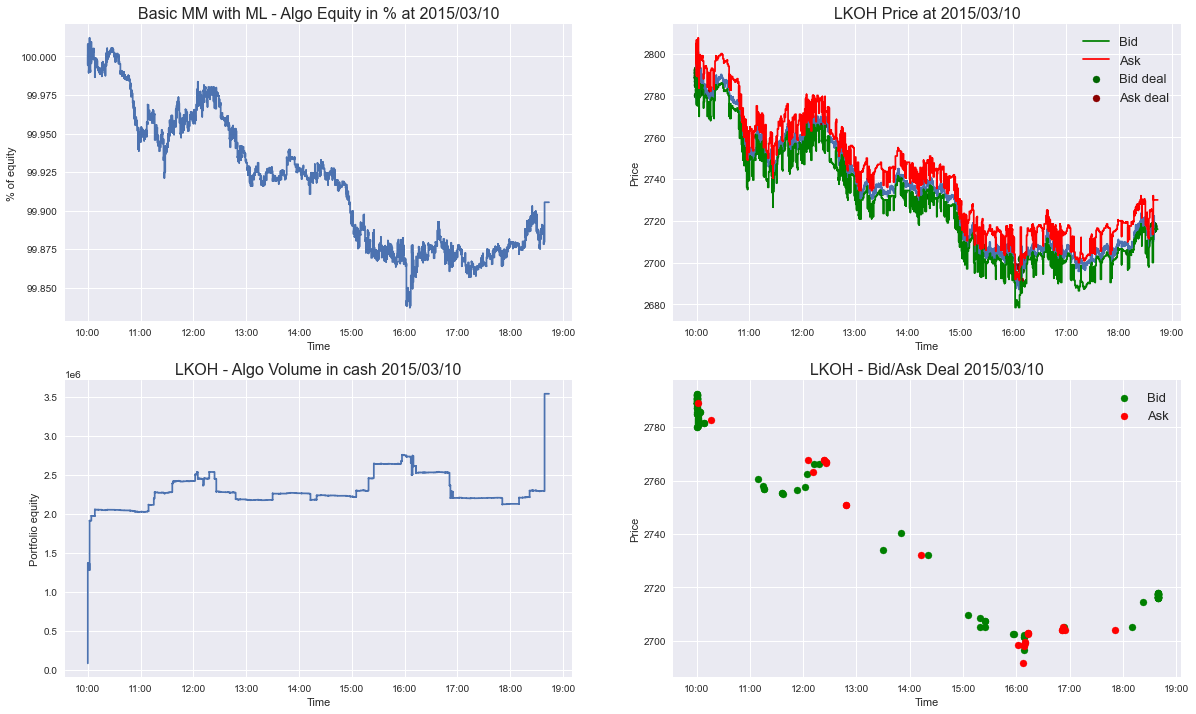

[{'Date': '20150310',
  'Num_of_trades': 139,
  'Algo_turnover': 6838862.6,
  'P&L': -47286.3,
  'Num_of_bought': 1897,
  'WA_bought_price': 2748.5,
  'Num_of_sold': 596,
  'WA_sold_price': 2726.5,
  'Open_Price': 2780.0,
  'Close_price': 2722.3,
  'Initial_cash': 50000000,
  'Mean_position': 2282526.5069854883,
  'End_Cash': 46411001.4,
  'End_Equity': 49952713.699999996,
  'Max_day_drawdown': -0.16,
  'Total_Return': -0.0945726}]

In [368]:
params=get_params(rf)
model = Basic_MM_with_ML(**params)
backtest_year(date, Matching_Engine(), model, enddate="20150310", share=share,
                                show_stat=True)

In [366]:
Counter(model.predictions)

Counter()

In [ ]:
params = get_params(cbst)
model = Basic_MM_with_ML(**params)
backtest_year(date, Matching_Engine(), model, enddate="20150310", share=share,
                                show_stat=True)

In [ ]:
Counter(model.predictions)

In [ ]:
params=get_params(lr)
model = Basic_MM_with_ML(**params)
backtest_year(date, Matching_Engine(), model, enddate="20150310", share=share,
                                show_stat=True)

In [ ]:
Counter(model.predictions)

In [345]:
from tqdm import tqdm 

date = "20150310"
dom = Matching_Engine()
errors = 0

isebergs = pd.read_csv("/Users/a185583357/Desktop/MOEX/OrderLog" + date + "/isebergs" + date + ".csv", index_col=0).to_dict()["vol"]
#TODO внедрить задержки для ММ
latency = 3 # ms
algo = Basic_MM_with_ML(**params)
algo_errors = 0
algo_orders = None

for i in tqdm(range(len(records))):
    record = records[i].copy()
    if algo_orders and int(record["TIME"]) > algo_orders[-1]["TIME"] + latency:
        out_algo = []
        for order in algo_orders:
            order["DATE"] = date
            try:
                order["SECCODE"] = share
                out = dom.check_order(order)
                if out:
                    out_algo.extend(out)
            except KeyboardInterrupt:
                break
            except:
                if order["ACTION"] == 1:
                    print("MAYBE Some problem, cant add order")
                    dom.check_order(order)
                    
                algo_errors += 1
        algo_orders = None
        if len(out_algo) > 0:
            algo.change_cash_share(out_algo)
   
    if record["ACTION"] == 1 and record["ORDERNO"] in isebergs:
        record["VOLUME"] = isebergs[record["ORDERNO"]]
    try:
        out = dom.check_order(record)
        algo.change_cash_share(out)
    except KeyboardInterrupt:
        break
    except:
        if record["ACTION"] == 1:
            print("MAYBE Some problem, cant add record")
            #dom.check_order(record)
            raise Exception
        errors += 1
    if not algo_orders:
        algo_orders = algo.trading(dom, time=record["TIME"], first_sma=max(records[1001]["PRICE"], records[1000]["PRICE"]))

 61%|██████    | 801324/1311311 [00:07<00:04, 108727.63it/s]


In [343]:
algo.raw_data

[array([[2.71000000e+03, 4.50000000e+01, 2.72750000e+03, 3.50000000e+02,
         2.71000000e+03, 5.00000000e+00, 1.00000000e+00, 0.00000000e+00,
         1.00001441e+08, 2.01503100e+07, 0.00000000e+00, 0.00000000e+00,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00]])]

In [ ]:
algo.